# False Positive Rate, Fingerprints, and Expansion

We test the false positive rate and its relation to fingerprint and expansion.

In [1]:
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
%matplotlib inline
from qf_probability_sum import qf_probability_sum

In [2]:
def parse_results(filename:str) -> Tuple[pd.DataFrame, float, int]:
    """
    Takes an input file name in .txt format, strips out the extra strings and returns 
    the main results in a dataframe.

    The universe size is the largest power of 2 that is used to insert into the sketch and 
    the capacity is how far along the power of two interval used for maximum cardinality.

    Eg. capacity = 0.9 and lgU = 20 means that we insert 0.9 * 2^20 elements into the sketch.

    Parameters:
        - filename (str): The path to the input file in .txt format.

        Returns:
        - Tuple[pd.DataFrame, float, int]: A tuple containing the main results in a dataframe, 
        the number of queries, and the number of false positives per query.
    """
    with open(filename) as f:
        lines = f.readlines()[2:]
    ignore_from_idx = lines.index("PROPERTIES:\n")
    results = lines[:ignore_from_idx-1] # there is an empty line preceding the ignore_from_idx
    results_clean = [r.strip("\n") for r in results]
    results_df = pd.DataFrame(sub.split("\t") for sub in results_clean[1:])
    results_df.columns = results_clean[0].split("\t")
    for col in results_df.columns:
        results_df[col] = pd.to_numeric(results_df[col])
    num_queries = None
    for line in lines:
        if "lgNumQueries" in line:
            num_queries = 2.**int(line.split("=")[-1])
            break
    results_df["trialFPR"] = results_df["NumFalsePositives"] / num_queries
    return results_df, int(num_queries)

## 1. False Positive Rate Bound for a fixed fingerprint

First, we check the FPR bound of $2^{-f}$ for a single fingerprint.
The configuration for this experiment is: $m = 2^{21}$ slots, and four points in the octave between $2^{20}$ and $2^{21}$.
For each trial, we generate a new input and query set $Q$ and count the number of false positives when testing the query set against the filter.
The query set has $|Q| = 4096$.

The number of false positives reported is approximately a Binomial distribution with $Q$ trials and probability $p$ of reporting a false positive as the Binomial success probability.


In [3]:
single_fingerprint_df, num_queries = parse_results("QuotientFilterExpansionProfile20240813_090828PST.txt")
single_fprint = single_fingerprint_df["FPrintLen"].values[0]

# ignore any fingerprints that are not the same length as the first fingerprint
single_fingerprint_df = single_fingerprint_df[single_fingerprint_df["FPrintLen"] == single_fprint]
single_fingerprint_df.head()

input_values = single_fingerprint_df["NumInput"].unique()
num_slots = single_fingerprint_df["NumSlots"].unique()[0]

In [4]:
num_slots, num_queries

(2097152, 4096)

In [5]:
def get_mean_entries_fpr(results_df:pd.DataFrame) -> np.ndarray:
    """
    Calculate the mean number of entries and false positive rate for each combination of "NumSlots" and "NumInput" in the given DataFrame.

    Parameters:
    - results_df (pd.DataFrame): The DataFrame containing the results.

    Returns:
    - np.ndarray: An array whose columns are the number of slots, mean number of entries in filterinput points and the mean of the number of entries and trial FPR.
    # first column is number of slots, second is number of entries, third is trial FPR
    """
    means = []
    for gg in results_df.groupby("NumSlots"):
        for gdf in gg[1].groupby("NumInput"):
            means.append([gg[0], gdf[1]["NumEntries"].mean(), gdf[1]["trialFPR"].mean(), gdf[1]["trialFPR"].median()])
    return np.array(means)

mean_num_entries_fpr = get_mean_entries_fpr(single_fingerprint_df)

In [7]:
mean_num_entries_fpr

array([[2.09715200e+06, 1.04042699e+06, 1.54996514e-02, 1.53808594e-02],
       [2.09715200e+06, 1.08923099e+06, 1.62308216e-02, 1.61132812e-02],
       [2.09715200e+06, 1.14030623e+06, 1.69944763e-02, 1.68457031e-02],
       [2.09715200e+06, 1.19375406e+06, 1.77892447e-02, 1.78222656e-02],
       [2.09715200e+06, 1.24968171e+06, 1.86212659e-02, 1.85546875e-02],
       [2.09715200e+06, 1.30820458e+06, 1.94831491e-02, 1.95312500e-02],
       [2.09715200e+06, 1.36943901e+06, 2.03975439e-02, 2.02636719e-02],
       [2.09715200e+06, 1.43350899e+06, 2.13514566e-02, 2.12402344e-02],
       [2.09715200e+06, 1.50054058e+06, 2.23572850e-02, 2.22167969e-02],
       [2.09715200e+06, 1.57067088e+06, 2.34036446e-02, 2.31933594e-02],
       [2.09715200e+06, 1.64403715e+06, 2.44902968e-02, 2.44140625e-02]])

Now we will plot the error behaviour as the number of entries in the filter increases.

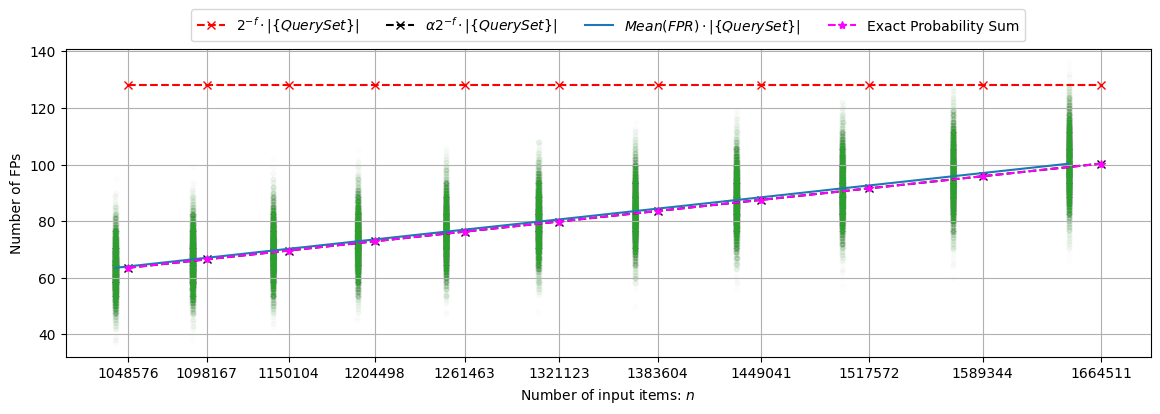

In [6]:
fig, ax = plt.subplots(figsize=(14, 4))

for i, g in enumerate(single_fingerprint_df.groupby("NumInput")):
    group = g[0]
    group_data = g[1]
    fprint_len = group_data["FPrintLen"].values[0]
    naive_bound = 2.**(-fprint_len)

    colour = "C" + str(group_data["FPrintLen"].values[0] -3)
    ax.scatter(group_data["NumEntries"], group_data["NumFalsePositives"], 
        color=colour, marker="o", s=10, alpha=0.01)
    

# bound function -- plotted at the input values points because the absolute load is a random variable that deviates 
# from a deterministic input cardinality.
ff = fprint_len*np.ones_like(input_values)
bound_fct = 2.**(-ff)
ax.plot(input_values, bound_fct*num_queries, 
        color="red", marker="x", label=r"$2^{-f}\cdot |\{QuerySet\}|$", linestyle="--")
ax.plot(input_values, (mean_num_entries_fpr[:,1]/mean_num_entries_fpr[:,0])*bound_fct*num_queries, 
        label=r"$\alpha 2^{-f} \cdot |\{QuerySet\}|$", color="black", marker="x", linestyle="--")


# Mean operator is linear in this setting
ax.plot(mean_num_entries_fpr[:,1], mean_num_entries_fpr[:,2]*num_queries, label=r"$Mean(FPR)\cdot |\{QuerySet\}|$")

# Exact probability sum
exact_probs = np.array([qf_probability_sum(num_slots, n, fprint_len) for n in input_values])
ax.plot(input_values, exact_probs*num_queries, label="Exact Probability Sum", color="magenta", marker="*", linestyle="--")

# # tidy the axes
ax.set_ylabel("Number of FPs")
ax.set_xlabel("Number of input items: $n$")

slot_ticks = single_fingerprint_df["NumInput"].unique().tolist()
ax.set_xticks(slot_ticks)
ax.ticklabel_format(style='plain')
ax.grid()
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)

#fig.savefig("single_fp_results_count.pdf")

Now subtract the mean to get a better idea of how the variance behaves as input items increase.
We see that the variance is mildly increasing.  This is to be expected since each of the independent trials represents a draw from a $Binomial(Q, p)$ distribution
(where $p$ is the probability of a false positive) whose variance is proportional to $p(1-p)$ which is increasing on $(0,\frac12)$.  Indeed we see that the empirical standard deviation closely matches that predicted from the theory.

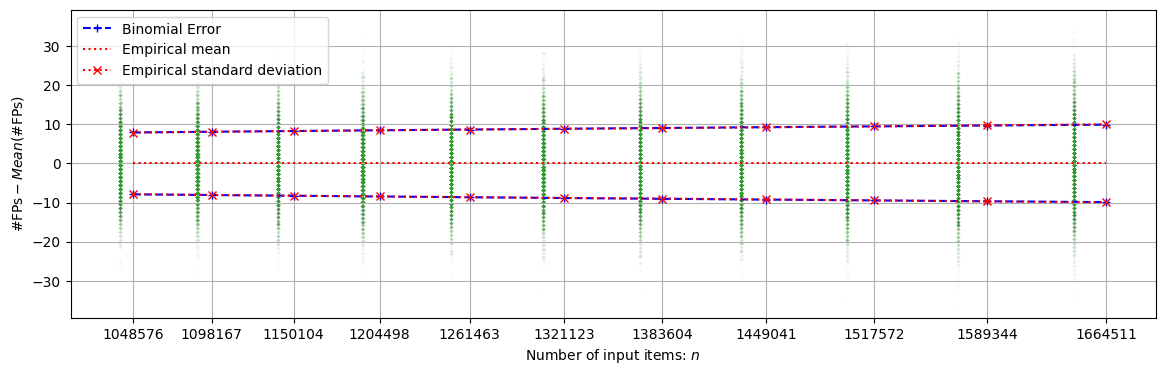

In [8]:
fig, ax = plt.subplots(figsize=(14, 4))

num_fp_means = []
num_fp_stds = []
for i, g in enumerate(single_fingerprint_df.groupby("NumInput")):
    group = g[0]
    group_data = g[1]
    fprint_len = group_data["FPrintLen"].values[0]
    load_factor = group_data["NumEntries"] / group_data["NumSlots"]
    fps_less_mean = group_data["NumFalsePositives"]- group_data["NumFalsePositives"].mean()
    num_fp_means.append(fps_less_mean.mean())
    num_fp_stds.append(fps_less_mean.std())
    
    colour = "C" + str(group_data["FPrintLen"].values[0] -3)

    ax.scatter(group_data["NumEntries"], fps_less_mean, 
        color=colour, marker=".", s=10, alpha=0.01)
    

# Binomial error terms
ax.plot(input_values, np.sqrt(exact_probs*(1-exact_probs)*num_queries), label="Binomial Error", color="blue", marker="+", linestyle="--")
ax.plot(input_values, -np.sqrt(exact_probs*(1-exact_probs)*num_queries), color="blue", marker="+", linestyle="--")

# Mean and standard deviations of FPs less mean
ax.plot(input_values, num_fp_means, label="Empirical mean", color="red", linestyle=":")
ax.plot(input_values, num_fp_stds, label="Empirical standard deviation", color="red", marker="x", linestyle=":")
ax.plot(input_values, -np.array(num_fp_stds), color="red", marker="x", linestyle=":")

# # tidy the axes
ax.set_ylabel(r"$\# \text{FPs} - Mean(\# \text{FPs})$")
ax.set_xlabel("Number of input items: $n$")

slot_ticks = single_fingerprint_df["NumInput"].unique().tolist()
ax.set_xticks(slot_ticks)
ax.ticklabel_format(style='plain')
ax.grid()
ax.legend(loc="upper left")

In [9]:
# empirical and mathematical standard deviations
np.c_[num_fp_stds, np.sqrt(exact_probs*(1-exact_probs)*num_queries)]

array([[7.86102209, 7.90683742],
       [8.05846448, 8.08716986],
       [8.25690964, 8.27140107],
       [8.4470204 , 8.45959971],
       [8.63977779, 8.65182699],
       [8.83408323, 8.84815939],
       [8.99173992, 9.04866053],
       [9.22347582, 9.25340337],
       [9.4533194 , 9.46244994],
       [9.73107549, 9.67586922],
       [9.98112535, 9.89372946]])

Now we use the same results to estimate the false positive rate by dividing out the number of query points normalising constant.

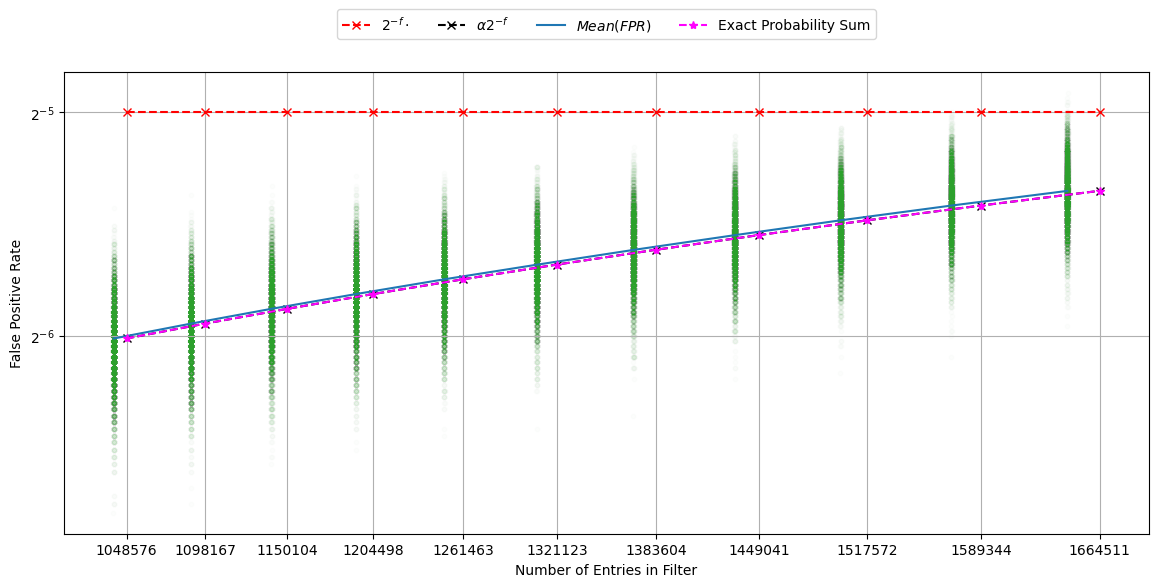

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))
for i, g in enumerate(single_fingerprint_df.groupby("NumInput")):
    group = g[0]
    group_data = g[1]
    fprint_len = group_data["FPrintLen"].values[0]

    naive_bound = 2.**(-fprint_len)

    colour = "C" + str(group_data["FPrintLen"].values[0] -3)
    ax.scatter(group_data["NumEntries"], group_data["NumFalsePositives"]/num_queries, 
        color=colour, marker="o", s=10, alpha=0.01)
    

# bound function
ff = fprint_len*np.ones_like(input_values)
bound_fct = 2.**(-ff)
ax.plot(input_values, bound_fct, 
        color="red", marker="x", label=r"$2^{-f}\cdot$", linestyle="--")
ax.plot(input_values, (mean_num_entries_fpr[:,1]/mean_num_entries_fpr[:,0])*bound_fct, 
        label=r"$\alpha 2^{-f}$", color="black", marker="x", linestyle="--")

ax.plot(mean_num_entries_fpr[:,1], mean_num_entries_fpr[:,2], label=r"$Mean(FPR)$")
ax.plot(input_values, exact_probs, label="Exact Probability Sum", color="magenta", marker="*", linestyle="--")

# tidy the axes
ax.set_ylabel("False Positive Rate")
ax.set_xlabel("Number of Entries in Filter")

slot_ticks = single_fingerprint_df["NumInput"].unique().tolist()
ax.set_xticks(slot_ticks)
ax.ticklabel_format(style='plain')
ax.grid()
ax.set_yscale("log", base=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)

0.01550, 0.01526, 0.01550, 0.01526
0.01623, 0.01597, 0.01623, 0.01597
0.01699, 0.01670, 0.01699, 0.01671
0.01779, 0.01747, 0.01779, 0.01747
0.01862, 0.01827, 0.01862, 0.01827
0.01949, 0.01911, 0.01948, 0.01910
0.02041, 0.01999, 0.02040, 0.01998
0.02136, 0.02090, 0.02135, 0.02090
0.02236, 0.02186, 0.02236, 0.02186
0.02340, 0.02286, 0.02340, 0.02286
0.02450, 0.02390, 0.02449, 0.02389


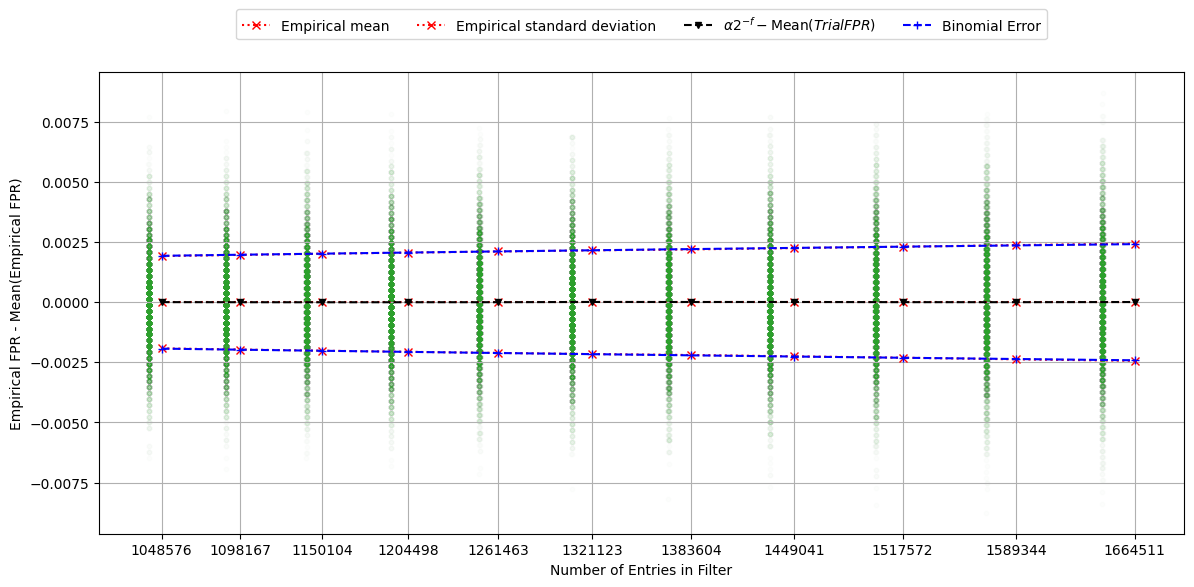

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))

fpr_means = []
fpr_stds = []
approx_bound = []
for i, g in enumerate(single_fingerprint_df.groupby("NumInput")):
    group = g[0]
    group_data = g[1]
    fprint_len = group_data["FPrintLen"].values[0]
    fps_less_mean = group_data["trialFPR"]- group_data["trialFPR"].mean()
    fpr_means.append(fps_less_mean.mean())
    fpr_stds.append(fps_less_mean.std())
    mean_load = (group_data["NumEntries"] / group_data["NumSlots"]).mean()
    p = mean_load*2.**(-fprint_len)
    p_emp = group_data["trialFPR"].mean()
    print(f"{p:.5f}, {p*(1-p):.5f}, {p_emp:.5f}, {p_emp*(1-p_emp):.5f}")
    approx_bound.append(mean_load*2.**(-fprint_len) - group_data["trialFPR"].mean())

    colour = "C" + str(group_data["FPrintLen"].values[0] -3)
    ax.scatter(group_data["NumEntries"], fps_less_mean, color=colour, marker="o", s=10, alpha=0.01)


# empirical mean and standard deviations of FPs less mean
ax.plot(input_values, fpr_means, label="Empirical mean", color="red", marker="x", linestyle=":")
ax.plot(input_values, fpr_stds, label="Empirical standard deviation", color="red", marker="x", linestyle=":")
ax.plot(input_values, -np.array(fpr_stds), color="red", marker="x", linestyle=":")

# add the simple bound back in
ax.plot(input_values, approx_bound, label=r"$\alpha 2^{-f} - \text{Mean}(TrialFPR)$", color="black", marker="v", markersize=5., linestyle="--")

# Binomial error terms
ax.plot(input_values, np.sqrt(exact_probs*(1-exact_probs)/num_queries), label="Binomial Error", color="blue", marker="+", linestyle="--")
ax.plot(input_values, -np.sqrt(exact_probs*(1-exact_probs)/num_queries), color="blue", marker="+", linestyle="--")

# tidy the axes
ax.set_ylabel("Empirical FPR - Mean(Empirical FPR)")
ax.set_xlabel("Number of Entries in Filter")

slot_ticks = single_fingerprint_df["NumInput"].unique().tolist()
ax.set_xticks(slot_ticks)
ax.ticklabel_format(style='plain')
ax.grid()
#ax.set_yscale("log", base=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)

Overall, what we see from this plot is that a slightly more refined bound can be given to the user given information in the filter.
Namely, the load can be calculated and this value can be used to scale the $2^{-f}$ function.  The plot above shows that the function 
$\alpha 2^{-f} - \text{Mean}(TrialFPR)$ is centered on zero, so on average there is little difference between the two functions.

In [12]:
print(f"{'NumSlots':<10} {'NumInput':<10} {'NumEntries':<10} {'FPrintLen':<10} {'MedNumFPs':<10} {'MaxNumFPs':<10} {'nBadTrial':<10} {'MeanFPR':<10} {'stdFPR':<10} {'WorstFPR':<10} {'Bound':<10}")
print("-"*90)

for g in single_fingerprint_df.groupby("NumInput"):
    
    num_slots = g[1]["NumSlots"].values[0]
    fprint_len = g[1]["FPrintLen"].values[0]
    num_entries = g[1]["NumEntries"].median()
    med_num_fps = g[1]["NumFalsePositives"].median()
    max_num_fps = g[1]["NumFalsePositives"].max()
    mean_fpr = g[1]["trialFPR"].mean()
    std_fpr = g[1]["trialFPR"].std()
    worst_fpr = g[1]['trialFPR'].max()
    bound = 2.**(-fprint_len)
    thld = np.floor(num_queries * bound).astype(int)
    g[1]["BadTrial"] = g[1]["NumFalsePositives"] > thld
    num_bad_trials = g[1]["BadTrial"].sum() 
    print(f"{num_slots:<10} {g[0]:<10} {num_entries:<10} {fprint_len:<10} {med_num_fps:<10} {max_num_fps:<10} {num_bad_trials:<10} {mean_fpr:<10.4f} {std_fpr:<10.4f} {worst_fpr:<10.4f} {bound:<10.4f}")


NumSlots   NumInput   NumEntries FPrintLen  MedNumFPs  MaxNumFPs  nBadTrial  MeanFPR    stdFPR     WorstFPR   Bound     
------------------------------------------------------------------------------------------
2097152    1048576    1040426.0  5          63.0       95         0          0.0155     0.0019     0.0232     0.0312    
2097152    1098167    1089232.0  5          66.0       99         0          0.0162     0.0020     0.0242     0.0312    
2097152    1150104    1140308.0  5          69.0       102        0          0.0170     0.0020     0.0249     0.0312    
2097152    1204498    1193754.0  5          73.0       105        0          0.0178     0.0021     0.0256     0.0312    
2097152    1261463    1249681.0  5          76.0       106        0          0.0186     0.0021     0.0259     0.0312    
2097152    1321123    1308203.0  5          80.0       108        0          0.0195     0.0022     0.0264     0.0312    
2097152    1383604    1369436.0  5          83.0       115    

## 2. False Positive Rate Bound for varying fingerprint length
We should see similar behaviour to the above but across all fingerprint lengths.

In [13]:
multi_fingerprint_df, multi_fp_num_queries = parse_results("QuotientFilterExpansionProfile20240814_034519PST.txt")


multi_input_values = multi_fingerprint_df["NumInput"].unique()
multi_num_slots = multi_fingerprint_df["NumSlots"].unique()

multi_fingerprint_df.head()

,NumSlots,NumInput,FPrintLen,NumEntries,NumFalsePositives,trialFPR
0,2097152,1048576,5,1040474,72,0.017578
1,2097152,1098167,5,1089276,77,0.018799
2,2097152,1150104,5,1140311,79,0.019287
3,2097152,1204498,5,1193814,83,0.020264
4,2097152,1261463,5,1249723,86,0.020996


In [14]:
def get_fingerprint_lengths(df:pd.DataFrame) -> np.ndarray:
    """
    Get the fingerprint lengths in the given DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the fingerprint lengths.

    Returns:
    - np.ndarray: An array of the fingerprint lengths.
    """
    num_input_fprint_len_arr = []
    for g in df.groupby("NumInput"):
        num_input_fprint_len_arr.append([g[0], g[1]["FPrintLen"].values[0]])
    return np.array(num_input_fprint_len_arr)

In [15]:
unique_triples = multi_fingerprint_df[["NumSlots", "NumInput",	"FPrintLen"]].drop_duplicates()
print(len(unique_triples))

30


In [16]:
multi_exact_probs = np.zeros((len(unique_triples),), dtype=float)
for i, triple in enumerate(unique_triples.values):
    multi_exact_probs[i] = qf_probability_sum(*triple)

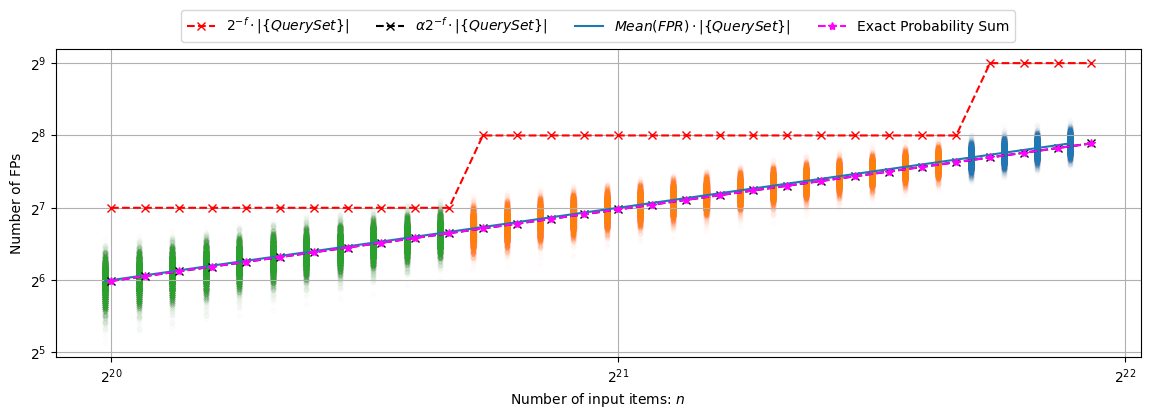

In [17]:
fig, ax = plt.subplots(figsize=(14, 4))

multi_mean_num_entries_fpr = get_mean_entries_fpr(multi_fingerprint_df)

for i, g in enumerate(multi_fingerprint_df.groupby("NumInput")):
    group = g[0]
    group_data = g[1]
    fprint_len = group_data["FPrintLen"].values[0]
    naive_bound = 2.**(-fprint_len)

    colour = "C" + str(group_data["FPrintLen"].values[0] -3)
    ax.scatter(group_data["NumEntries"], group_data["NumFalsePositives"], 
        color=colour, marker="o", s=10, alpha=0.01)
    

# bound function -- plotted at the input values points because the absolute load is a random variable that deviates 
# from a deterministic input cardinality.
inputs_and_fprint_lens = get_fingerprint_lengths(multi_fingerprint_df)
bound_fct = 2.**(-inputs_and_fprint_lens[:, 1])
ax.plot(inputs_and_fprint_lens[:, 0], bound_fct*multi_fp_num_queries, 
        color="red", marker="x", label=r"$2^{-f}\cdot |\{QuerySet\}|$", linestyle="--")
ax.plot(multi_input_values, (multi_mean_num_entries_fpr[:,1]/multi_mean_num_entries_fpr[:,0])*bound_fct*multi_fp_num_queries, 
        label=r"$\alpha 2^{-f} \cdot |\{QuerySet\}|$", color="black", marker="x", linestyle="--")


# Mean operator is linear in this setting
ax.plot(multi_mean_num_entries_fpr[:,1], multi_mean_num_entries_fpr[:,2]*multi_fp_num_queries, label=r"$Mean(FPR)\cdot |\{QuerySet\}|$")

# Exact probability sum
ax.plot(multi_input_values, multi_exact_probs*num_queries, label="Exact Probability Sum", color="magenta", marker="*", linestyle="--")

# tidy the axes
ax.set_ylabel("Number of FPs")
ax.set_xlabel("Number of input items: $n$")
ax.set_yscale("log", base=2)
ax.set_xscale("log", base=2)
ax.grid()
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)

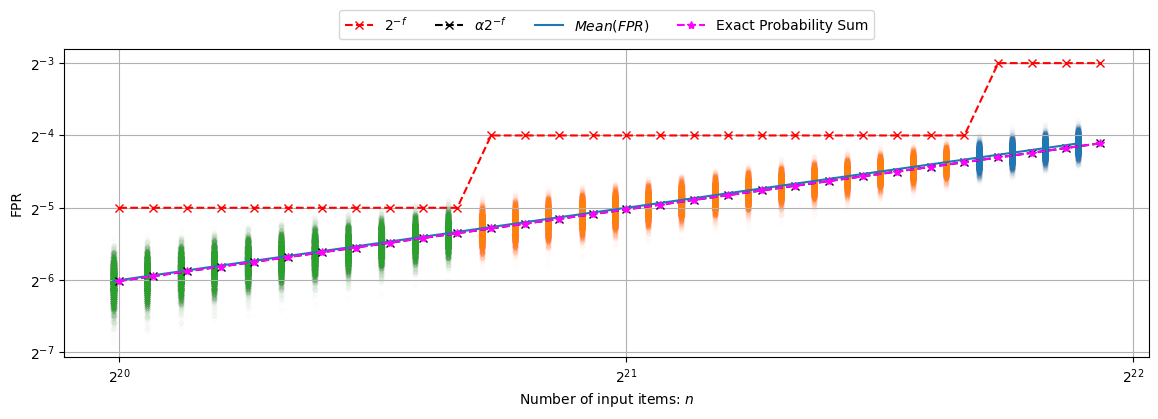

In [18]:
fig, ax = plt.subplots(figsize=(14, 4))

multi_mean_num_entries_fpr = get_mean_entries_fpr(multi_fingerprint_df)

for i, g in enumerate(multi_fingerprint_df.groupby("NumInput")):
    group = g[0]
    group_data = g[1]
    fprint_len = group_data["FPrintLen"].values[0]
    naive_bound = 2.**(-fprint_len)

    colour = "C" + str(group_data["FPrintLen"].values[0] -3)
    ax.scatter(group_data["NumEntries"], group_data["trialFPR"], 
        color=colour, marker="o", s=10, alpha=0.01)
    

# bound function -- plotted at the input values points because the absolute load is a random variable that deviates 
# from a deterministic input cardinality.
inputs_and_fprint_lens = get_fingerprint_lengths(multi_fingerprint_df)
bound_fct = 2.**(-inputs_and_fprint_lens[:, 1])
ax.plot(inputs_and_fprint_lens[:, 0], bound_fct, 
        color="red", marker="x", label=r"$2^{-f}$", linestyle="--")
ax.plot(multi_input_values, (multi_mean_num_entries_fpr[:,1]/multi_mean_num_entries_fpr[:,0])*bound_fct, 
        label=r"$\alpha 2^{-f}$", color="black", marker="x", linestyle="--")


# Mean operator is linear in this setting
ax.plot(multi_mean_num_entries_fpr[:,1], multi_mean_num_entries_fpr[:,2], label=r"$Mean(FPR)$")

# Exact probability sum
ax.plot(multi_input_values, multi_exact_probs, label="Exact Probability Sum", color="magenta", marker="*", linestyle="--")

# tidy the axes
ax.set_ylabel("FPR")
ax.set_xlabel("Number of input items: $n$")
ax.set_yscale("log", base=2)
ax.set_xscale("log", base=2)
ax.grid()
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=4)

We see the same behaviour as for the single fingerprint length even when the filter expands.
Different colours represent different fingerprint lengths.  The three groups are $5, 4, 3$ from left to right in green, orange, and blue.